In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras 
import matplotlib.pyplot as plt 
import sys 
sys.path.append('../') 
from layer_approx_utils import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
test_images = np.expand_dims(test_images.astype("float32")/255.0,-1)
test_labels = test_labels.astype("float32")
train_images = np.expand_dims(train_images.astype("float32")/255.0,-1)
train_labels = train_labels.astype("float32")
val_images = train_images[-10000:]
val_labels = train_labels[-10000:]
train_images = train_images[:-10000]
train_labels = train_labels[:-10000]
# random shuffling is very very important ...
np.random.seed(8)
ind = np.random.choice(train_images.shape[0], train_images.shape[0], replace=False)
train_images = train_images[ind, :]
train_labels = train_labels[ind]

run_mode = 1

In [4]:
if run_mode == 1:
    loadedModel = keras.models.load_model('Lenet_Mnist_Run1')
    origLoss, origAccuracy = loadedModel.evaluate(test_images, test_labels, batch_size=128, verbose=0)
    loadedModel.summary()
    initial_size = 6*5*5*1 + 6  + 16*5*5*6 + 16 + 256*120 + 120 + 120*84 + 84 + 84*10 + 10
else:
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    origLoss, origAccuracy = loadedModel.evaluate(test_images, test_labels, batch_size=128, verbose=0)
    loadedModel.summary()
    initial_size = 6*5*5*1 + 6  + 16*5*5*6 + 16 + 256*120 + 120 + 120*84 + 84 + 84*10 + 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 12, 12, 6)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 8, 8, 16)          2416      
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                1

In [6]:
class sparseLayerlocal(keras.layers.Layer):
    def __init__(self, n_input=None, n_output=None, Wip=None, Mip=None, bias_ip=None):
        
        super(sparseLayerlocal, self).__init__()
        
        if Wip is None:
            w_init = tf.random_normal_initializer()
            self.W = tf.Variable(initial_value=w_init(shape=(n_input,n_output)),
                                dtype="float32",
                                trainable=True)
        else:
            self.W = tf.Variable(initial_value=Wip, 
                                dtype="float32",
                                trainable=True)
                    
        if Mip is None:
            self.M = tf.Variable(intial_value = tf.ones(shape=(n_input,n_output), dtype="float32"),
                                     dtype="float32",
                                     trainable=False)
        else:
            self.M = tf.Variable(initial_value = Mip,
                                 dtype="float32",
                                 trainable=False)
        
        if bias_ip is None:
            b_init = tf.zeros_initializer()
            self.b = tf.Variable(initial_value=b_init(shape=(n_output,)), 
                             dtype="float32", 
                             trainable=True)
        else:
            self.b = tf.Variable(initial_value=bias_ip, 
                             dtype="float32", 
                             trainable=True)
            
    def call(self, x):
        x = tf.matmul(x, tf.multiply(self.M, self.W)) + self.b
        return tf.nn.relu(x)

In [7]:
def getResultsDLR(U_file, model_file, thr, layer_idx, finetune_results=False):
   
    U_dict = np.load(U_file,allow_pickle=True).item()
    
    acc_DLR = []
    if finetune_results:
        acc_DLR_finetuned = []
    ranks = []

    for epsilon, W in U_dict.items():
        
        [U,S,V] = np.linalg.svd(W)
        rank = np.count_nonzero(S>thr)
        U = np.dot(U[:,:rank], np.diag(S[:rank]))
        V = V[:rank, :]
        ranks.append(rank)
        
        low_rank_layer = lowrankLayer(W.shape[0], W.shape[1], rank)
        dum = low_rank_layer(tf.ones(shape=(1, W.shape[0])))     # for proper initialization   
        
        loadedModel = keras.models.load_model(model_file)
        bias = getLayerBias(loadedModel, layer_idx)
        low_rank_layer.set_weights([U,V,bias])

        new_layer_list = [keras.Input(shape=(28,28,1))]
        for i,layer in enumerate(loadedModel.layers):
            if i == layer_idx:
                new_layer_list.append(low_rank_layer)
            else:
                layer.trainable = False
                new_layer_list.append(layer)

        LenetModel_Approx = keras.Sequential(new_layer_list)
        LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                       loss=keras.losses.SparseCategoricalCrossentropy(), 
                       metrics=[keras.metrics.SparseCategoricalAccuracy()])

        loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128, verbose=0)
        acc_DLR.append(acc)
        
        if finetune_results:
            LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=5, validation_data=(val_images, val_labels))
            loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
            acc_DLR_finetuned.append(acc)     
    
    sizes = []
    
    if layer_idx == 5:
        for rank in ranks:
            size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  (256 + 120)*rank + 120 +  120*84 + 84 +  84*10 +10
            sizes.append(size)
    
    if layer_idx == 6:
        for rank in ranks:
            size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  256 * 120 + 120 +  (120+84)*rank + 84 +  84*10 +10
            sizes.append(size)

    
    
    if finetune_results:
        return np.array(ranks), np.array(sizes), np.array(acc_DLR), np.array(acc_DLR_finetuned)
    else:
        return np.array(ranks), np.array(sizes), np.array(acc_DLR)

In [8]:
def getResultsLR(ranks, model_file, layer_idx, N_trn) :
    
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    test_images = np.expand_dims(test_images.astype("float32")/255.0,-1)
    test_labels = test_labels.astype("float32")
    train_images = np.expand_dims(train_images.astype("float32")/255.0,-1)
    train_labels = train_labels.astype("float32")
    val_images = train_images[-10000:]
    val_labels = train_labels[-10000:]
    train_images = train_images[:-10000]
    train_labels = train_labels[:-10000]
    # random shuffling is very very important ...
    np.random.seed(8)
    ind = np.random.choice(train_images.shape[0], train_images.shape[0], replace=False)
    train_images = train_images[ind, :]
    train_labels = train_labels[ind]

    train_images = train_images[:N_trn]
    train_labels = train_labels[:N_trn]
    acc_LR_finetuned = []
    
    for rank in ranks:

        loadedModel = keras.models.load_model(model_file)
        W = loadedModel.get_layer(index=layer_idx).get_weights()[0]
        bias  = loadedModel.get_layer(index=layer_idx).get_weights()[1]

        [U,S,V] = np.linalg.svd(W)
        U = np.dot(U[:,:rank], np.diag(S[:rank]))
        V = V[:rank, :]

        low_rank_layer = lowrankLayer(W.shape[0], W.shape[1], rank)
        dum = low_rank_layer(tf.ones(shape=(1, W.shape[0])))     # for proper initialization   
        low_rank_layer.set_weights([U,V,bias])

        new_layer_list = [keras.Input(shape=(28,28,1))]
        for i,layer in enumerate(loadedModel.layers):
            if i == layer_idx:
                new_layer_list.append(low_rank_layer)
            else:
                #layer.trainable = False
                new_layer_list.append(layer)

        LenetModel_Approx = keras.Sequential(new_layer_list)
        LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                       loss=keras.losses.SparseCategoricalCrossentropy(), 
                       metrics=[keras.metrics.SparseCategoricalAccuracy()])

        LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=5, validation_data=(val_images, val_labels), verbose=0)
        loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128, verbose=0)
        acc_LR_finetuned.append(acc)     

    return np.array(acc_LR_finetuned)

In [9]:
def getResultsNetTrim(U_file, model_file, thr, layer_idx, finetune_results=False):

    U_dict = np.load(U_file,allow_pickle=True).item()
    
    acc_nettrim = []
    if finetune_results:
        acc_netTrim_finetuned = []
    nnzs = []

    for epsilon, W in U_dict.items():
        
        W[np.abs(W)<=thr] = 0.0
        M = np.ones_like(W, dtype="float32")
        M[np.abs(W)<=thr] = 0.0
        W = W.astype("float32")
        M = M.astype("float32")
        nnz = np.count_nonzero(W)
        nnzs.append(nnz)
                            
        loadedModel = keras.models.load_model(model_file)
        bias = getLayerBias(loadedModel, layer_idx)

        sparseLayer = sparseLayerlocal(n_input=W.shape[0], n_output=W.shape[1], Wip=W, Mip=M, bias_ip=bias)

        new_layer_list = [keras.Input(shape=(28,28,1))]
        for i,layer in enumerate(loadedModel.layers):
            if i == layer_idx:
                new_layer_list.append(sparseLayer)
            else:
                #layer.trainable = False
                new_layer_list.append(layer)

        LenetModel_Approx = keras.Sequential(new_layer_list)
        LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                       loss=keras.losses.SparseCategoricalCrossentropy(), 
                       metrics=[keras.metrics.SparseCategoricalAccuracy()])

        loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128, verbose=0)
        acc_nettrim.append(acc)
        
        if finetune_results:
            LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=1, validation_data=(val_images, val_labels))
            loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
            acc_nettrim_finetuned.append(acc)     
    
    sizes = []
    
    if layer_idx == 5:
        for nnz in nnzs:
            size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  3*nnz + 120 +  120*84 + 84 +  84*10 +10
            sizes.append(size)
    
    if layer_idx == 6:
        for nnz in nnzs:
            size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  256 * 120 + 120 +  3*nnz + 84 +  84*10 +10
            sizes.append(size)

    
    if finetune_results:
        return np.array(nnzs), np.array(sizes), np.array(acc_nettrim), np.array(acc_nettrim_finetuned)
    else:
        return np.array(nnzs), np.array(sizes), np.array(acc_nettrim)

In [10]:
def getCombinedResultsLR(ranks_layer1, ranks_layer2, model_file, N_tr):
    #acc_LR_combiend = []
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    test_images = np.expand_dims(test_images.astype("float32")/255.0,-1)
    test_labels = test_labels.astype("float32")
    train_images = np.expand_dims(train_images.astype("float32")/255.0,-1)
    train_labels = train_labels.astype("float32")
    val_images = train_images[-10000:]
    val_labels = train_labels[-10000:]
    train_images = train_images[:-10000]
    train_labels = train_labels[:-10000]
    # random shuffling is very very important ...
    np.random.seed(8)
    ind = np.random.choice(train_images.shape[0], train_images.shape[0], replace=False)
    train_images = train_images[ind, :]
    train_labels = train_labels[ind]

    train_images = train_images[:N_tr]
    train_labels = train_labels[:N_tr]
    acc_LR_finetuned = []
    ranks = []
    for rank1, rank2 in zip(ranks_layer1, ranks_layer2):

        loadedModel = keras.models.load_model(model_file)
        W1 = loadedModel.get_layer(index=5).get_weights()[0]
        bias1  = loadedModel.get_layer(index=5).get_weights()[1]
        [U1,S1,V1] = np.linalg.svd(W1)
        U1 = np.dot(U1[:,:rank1], np.diag(S1[:rank1]))
        V1 = V1[:rank1, :]

        W2 = loadedModel.get_layer(index=6).get_weights()[0]
        bias2  = loadedModel.get_layer(index=6).get_weights()[1]
        [U2,S2,V2] = np.linalg.svd(W2)
        U2 = np.dot(U2[:,:rank2], np.diag(S2[:rank2]))
        V2 = V2[:rank2, :]


        low_rank_layer1 = lowrankLayer(W1.shape[0], W1.shape[1], rank1)
        dum = low_rank_layer1(tf.ones(shape=(1, W1.shape[0])))     # for proper initialization   
        low_rank_layer1.set_weights([U1,V1,bias1])

        bias2 = getLayerBias(loadedModel, 6)
        low_rank_layer2 = lowrankLayer(W2.shape[0], W2.shape[1], rank2)
        dum = low_rank_layer2(tf.ones(shape=(1, W2.shape[0])))     # for proper initialization   
        low_rank_layer2.set_weights([U2,V2,bias2])

        new_layer_list = [keras.Input(shape=(28,28,1))]
        for i,layer in enumerate(loadedModel.layers):
            if i == 5:
                new_layer_list.append(low_rank_layer1)
            elif i == 6:
                new_layer_list.append(low_rank_layer2)
            else:
                #layer.trainable = False
                new_layer_list.append(layer)

        LenetModel_Approx = keras.Sequential(new_layer_list)
        LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                       loss=keras.losses.SparseCategoricalCrossentropy(), 
                       metrics=[keras.metrics.SparseCategoricalAccuracy()])

#         loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
#         acc_LR.append(acc)
        LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=5, validation_data=(val_images, val_labels), verbose=0)
        loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128, verbose=0)
        acc_LR_finetuned.append(acc)     

    #acc_LR_combined = np.array(acc_LR)
    #acc_LR_finetuned_combined = np.array(acc_LR_finetuned)
    return np.array(acc_LR_finetuned)

In [11]:
def getCombinedResultsDLR(U_file_1, U_file_2, model_file, ranks_layer1, ranks_layer2):
    U_dict_layer1 = np.load(U_file_1, allow_pickle=True).item()
    U_dict_layer2 = np.load(U_file_2, allow_pickle=True).item()
    acc_DLR = []
    ranks = []
    for key1, key2, rank1, rank2 in zip(U_dict_layer1.keys(), U_dict_layer2.keys(), ranks_layer1, ranks_layer2):

        W1 = U_dict_layer1[key1]
        [U1,S1,V1] = np.linalg.svd(W1)
        U1 = np.dot(U1[:,:rank1], np.diag(S1[:rank1]))
        V1 = V1[:rank1, :]

        W2 = U_dict_layer2[key2]
        [U2,S2,V2] = np.linalg.svd(W2)
        U2 = np.dot(U2[:,:rank2], np.diag(S2[:rank2]))
        V2 = V2[:rank2, :]

        loadedModel = keras.models.load_model(model_file)

        bias1 = getLayerBias(loadedModel, 5)
        low_rank_layer1 = lowrankLayer(W1.shape[0], W1.shape[1], rank1)
        dum = low_rank_layer1(tf.ones(shape=(1, W1.shape[0])))     # for proper initialization   
        low_rank_layer1.set_weights([U1,V1,bias1])

        bias2 = getLayerBias(loadedModel, 6)
        low_rank_layer2 = lowrankLayer(W2.shape[0], W2.shape[1], rank2)
        dum = low_rank_layer2(tf.ones(shape=(1, W2.shape[0])))     # for proper initialization   
        low_rank_layer2.set_weights([U2,V2,bias2])

        new_layer_list = [keras.Input(shape=(28,28,1))]
        for i,layer in enumerate(loadedModel.layers):
            if i == 5:
                new_layer_list.append(low_rank_layer1)
            elif i == 6:
                new_layer_list.append(low_rank_layer2)
            else:
                #layer.trainable = False
                new_layer_list.append(layer)

        LenetModel_Approx = keras.Sequential(new_layer_list)
        LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                       loss=keras.losses.SparseCategoricalCrossentropy(), 
                       metrics=[keras.metrics.SparseCategoricalAccuracy()])

        loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128, verbose=0)
        acc_DLR.append(acc)    

    acc_DLR_combined= np.array(acc_DLR)
    size_with_combined = []
    for rank1, rank2 in zip(ranks_layer1, ranks_layer2):
        size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  (256 + 120)*rank1 + 120 +  (120+ 84)*rank2 + 84 +  84*10 +10
        size_with_combined.append(size)
    return np.array(size_with_combined), acc_DLR_combined

In [12]:

def getCombinedResultsNettrim(U_file_1, U_file_2, model_file, thr):

    U_dict_layer1 = np.load(U_file_1, allow_pickle=True).item()
    U_dict_layer2 = np.load(U_file_2, allow_pickle=True).item()
    acc_nettrim = []
    nnzs_1 = []
    nnzs_2 = []
    for eps1, eps2 in zip(U_dict_layer1.keys(), U_dict_layer2.keys()):

        W = U_dict_layer1[eps1]
        W[np.abs(W)<=thr] = 0.0
        M = np.ones_like(W, dtype="float32")
        M[np.abs(W)<=thr] = 0.0
        W = W.astype("float32")
        M = M.astype("float32")
        nnz = np.count_nonzero(W)
        nnzs_1.append(nnz)

        loadedModel = keras.models.load_model(model_file)
        bias = getLayerBias(loadedModel, 5)

        sparseLayer1 = sparseLayerlocal(n_input=W.shape[0], n_output=W.shape[1], Wip=W, Mip=M, bias_ip=bias)

        W = U_dict_layer2[eps2]
        W[np.abs(W)<=thr] = 0.0
        M = np.ones_like(W, dtype="float32")
        M[np.abs(W)<=thr] = 0.0
        W = W.astype("float32")
        M = M.astype("float32")
        nnz = np.count_nonzero(W)
        nnzs_2.append(nnz)

        loadedModel = keras.models.load_model(model_file)
        bias = getLayerBias(loadedModel, 6)

        sparseLayer2 = sparseLayerlocal(n_input=W.shape[0], n_output=W.shape[1], Wip=W, Mip=M, bias_ip=bias)

        new_layer_list = [keras.Input(shape=(28,28,1))]
        for i,layer in enumerate(loadedModel.layers):
            if i == 5:
                new_layer_list.append(sparseLayer1)
            elif i == 6: 
                new_layer_list.append(sparseLayer2)
            else:
                #layer.trainable = False
                new_layer_list.append(layer)

        LenetModel_Approx = keras.Sequential(new_layer_list)
        LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                       loss=keras.losses.SparseCategoricalCrossentropy(), 
                       metrics=[keras.metrics.SparseCategoricalAccuracy()])

        loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128, verbose=0)
        acc_nettrim.append(acc)

        #LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=1, validation_data=(val_images, val_labels))
        #loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
        #cc_nettrim_finetuned.append(acc)     


   # acc_nettrim_finetuned_combined= np.array(acc_nettrim_finetuned)
    size_nettrim_combined = []
    for nnz_1, nnz_2 in zip(nnzs_1, nnzs_2):
        #size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  nnz_1 + nnz_1*np.log2(256*120)/32 + 120 + nnz_2 + nnz_2*np.log2(120*84)/32 + 84 +  84*10 +10
        size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  3*nnz_1  + 120 + 3*nnz_2  + 84 +  84*10 +10 # for csr format
        size_nettrim_combined.append(size)
        
        
    return np.array(size_nettrim_combined),  np.array(acc_nettrim)

In [13]:
if run_mode == 1:
    #ranks_layer1_512, sizes_with_layer1_512, acc_DLR_layer1_512 = getResultsDLR('approx_matrices/DLR_layer_1_Run1_N_512.npy', 'Lenet_Mnist_Run1', 0.5, 5, False)
    ranks_layer1_256, sizes_with_layer1_256, acc_DLR_layer1_256 = getResultsDLR('approx_matrices/DLR_layer_1_Run1_N_256.npy', 'Lenet_Mnist_Run1', 0.5, 5, False)
    ranks_layer1_128, sizes_with_layer1_128, acc_DLR_layer1_128 = getResultsDLR('approx_matrices/DLR_layer_1_Run1_N_128.npy', 'Lenet_Mnist_Run1', 0.5, 5, False)
    
    #acc_LR_finetuned_layer1_512 = getResultsLR(ranks_layer1_512, 'Lenet_Mnist_Run1', 5, 512)
    #acc_LR_finetuned_layer1_256 = getResultsLR(ranks_layer1_256, 'Lenet_Mnist_Run1', 5, 256)
    #acc_LR_finetuned_layer1_128 = getResultsLR(ranks_layer1_128, 'Lenet_Mnist_Run1', 5, 128)
    
    #nnzs_layer1_512, nettrim_size_with_layer1_512, acc_nettrim_layer1_512 = getResultsNetTrim('approx_matrices/net_trim_layer_1_Run1_N_512.npy', 'Lenet_Mnist_Run1', 0.0001, 5)
    nnzs_layer1_256, nettrim_size_with_layer1_256, acc_nettrim_layer1_256 = getResultsNetTrim('approx_matrices/net_trim_layer_1_Run1_N_256.npy', 'Lenet_Mnist_Run1', 0.0001, 5)
    nnzs_layer1_128, nettrim_size_with_layer1_128, acc_nettrim_layer1_128 = getResultsNetTrim('approx_matrices/net_trim_layer_1_Run1_N_128.npy', 'Lenet_Mnist_Run1', 0.0001, 5)
else:
    #ranks_layer1_512, sizes_with_layer1_512, acc_DLR_layer1_512 = getResultsDLR('approx_matrices/DLR_layer_1_Run2_N_512.npy', 'Lenet_Mnist_Run2', 0.5, 5, False)
    ranks_layer1_256, sizes_with_layer1_256, acc_DLR_layer1_256 = getResultsDLR('approx_matrices/DLR_layer_1_Run2_N_256.npy', 'Lenet_Mnist_Run2', 0.5, 5, False)
    ranks_layer1_128, sizes_with_layer1_128, acc_DLR_layer1_128 = getResultsDLR('approx_matrices/DLR_layer_1_Run2_N_128.npy', 'Lenet_Mnist_Run2', 0.5, 5, False)
    
    #acc_LR_finetuned_layer1_512 = getResultsLR(ranks_layer1_512,'Lenet_Mnist_Run2', 5, 512)
    #acc_LR_finetuned_layer1_256 = getResultsLR(ranks_layer1_256,'Lenet_Mnist_Run2', 5, 256)
    #acc_LR_finetuned_layer1_128 = getResultsLR(ranks_layer1_128,'Lenet_Mnist_Run2', 5, 128)
    
    #nnzs_layer1_512, nettrim_size_with_layer1_512, acc_nettrim_layer1_512 = getResultsNetTrim('approx_matrices/net_trim_layer_1_Run2_N_512.npy', 'Lenet_Mnist_Run2', 0.0001, 5)
    nnzs_layer1_256, nettrim_size_with_layer1_256, acc_nettrim_layer1_256 = getResultsNetTrim('approx_matrices/net_trim_layer_1_Run2_N_256.npy', 'Lenet_Mnist_Run2', 0.0001, 5)
    nnzs_layer1_128, nettrim_size_with_layer1_128, acc_nettrim_layer1_128 = getResultsNetTrim('approx_matrices/net_trim_layer_1_Run2_N_128.npy', 'Lenet_Mnist_Run2', 0.0001, 5)

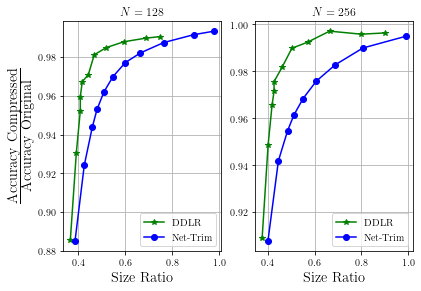

In [15]:
plt.rcParams.update({"text.usetex": True})

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout() 
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)

ax1.plot(sizes_with_layer1_128/initial_size, acc_DLR_layer1_128/origAccuracy, 'g-*', label=r'\textrm{DDLR}'  )
#ax1.plot(sizes_with_layer1_128/initial_size, acc_LR_finetuned_layer1_128/origAccuracy, 'r-^' , label=r'\textrm{ULR-ft}')
ax1.plot(nettrim_size_with_layer1_128/initial_size, acc_nettrim_layer1_128/origAccuracy, 'b-o',  label=r'\textrm{Net-Trim}')


ax2.plot(sizes_with_layer1_256/initial_size, acc_DLR_layer1_256/origAccuracy, 'g-*', label=r'\textrm{DDLR}'  )
#ax2.plot(sizes_with_layer1_256/initial_size, acc_LR_finetuned_layer1_256/origAccuracy, 'r-^' , label=r'\textrm{ULR-ft}')
ax2.plot(nettrim_size_with_layer1_256[2:]/initial_size, acc_nettrim_layer1_256[2:]/origAccuracy, 'b-o',  label=r'\textrm{Net-Trim}')

#ax3.plot(sizes_with_layer1_512/initial_size, acc_DLR_layer1_512/origAccuracy, 'g-*', label=r'\textrm{DDLR}' )
#ax3.plot(sizes_with_layer1_512/initial_size, acc_LR_finetuned_layer1_512/origAccuracy, 'r->', label=r'\textrm{ULR-ft}')
#ax3.plot(nettrim_size_with_layer1_512/initial_size, acc_nettrim_layer1_512/origAccuracy, 'b-o',   label=r'\textrm{Net-Trim}')

ax1.legend()
ax2.legend()


ax1.set_title(r'$N=128$')
ax2.set_title(r'$N=256$')
#ax3.set_title(r'$N=512$')
ax1.grid()
ax2.grid()
#ax3.grid()

ax1.set_xlabel(r'$\textrm{Size Ratio}$',fontsize='x-large')
ax2.set_xlabel(r'$\textrm{Size Ratio}$',fontsize='x-large')
#ax3.set_xlabel(r'$\textrm{Size Percentage}$',fontsize='x-large')

ax1.set_ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large', ha='center')
#ax2.set_ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large', ha='center')
#ax3.set_ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large', ha='center')
if run_mode == 1:
    plt.savefig('Figures/MNIST_layer1_Ntr_1024_final.pdf')
else:
    plt.savefig('Figures/MNIST_layer1_Ntr_512_final.pdf')

In [16]:
if run_mode == 1:
    #ranks_layer2_512, sizes_with_layer2_512, acc_DLR_layer2_512 = getResultsDLR('approx_matrices/DLR_layer_2_Run1_N_512.npy', 'Lenet_Mnist_Run1', 0.1, 6, False)
    ranks_layer2_256, sizes_with_layer2_256, acc_DLR_layer2_256 = getResultsDLR('approx_matrices/DLR_layer_2_Run1_N_256.npy', 'Lenet_Mnist_Run1', 0.1, 6, False)
    ranks_layer2_128, sizes_with_layer2_128, acc_DLR_layer2_128 = getResultsDLR('approx_matrices/DLR_layer_2_Run1_N_128.npy', 'Lenet_Mnist_Run1', 0.1, 6, False)

    #acc_LR_finetuned_layer2_512 = getResultsLR(ranks_layer2_512,'Lenet_Mnist_Run1', 6, 512)
    #acc_LR_finetuned_layer2_256 = getResultsLR(ranks_layer2_256,'Lenet_Mnist_Run1', 6, 256)
    #acc_LR_finetuned_layer2_128 = getResultsLR(ranks_layer2_128,'Lenet_Mnist_Run1', 6, 128)

    #nnzs_layer2_512, nettrim_size_with_layer2_512, acc_nettrim_layer2_512 = getResultsNetTrim('approx_matrices/net_trim_layer_2_Run1_N_512.npy', 'Lenet_Mnist_Run1', 0.0001, 6)
    nnzs_layer2_256, nettrim_size_with_layer2_256, acc_nettrim_layer2_256 = getResultsNetTrim('approx_matrices/net_trim_layer_2_Run1_N_256.npy', 'Lenet_Mnist_Run1', 0.0001, 6)
    nnzs_layer2_128, nettrim_size_with_layer2_128, acc_nettrim_layer2_128 = getResultsNetTrim('approx_matrices/net_trim_layer_2_Run1_N_128.npy', 'Lenet_Mnist_Run1', 0.0001, 6)
    
else:
    #ranks_layer2_512, sizes_with_layer2_512, acc_DLR_layer2_512 = getResultsDLR('approx_matrices/DLR_layer_2_Run2_N_512.npy', 'Lenet_Mnist_Run2', 0.1, 6, False)
    ranks_layer2_256, sizes_with_layer2_256, acc_DLR_layer2_256 = getResultsDLR('approx_matrices/DLR_layer_2_Run2_N_256.npy', 'Lenet_Mnist_Run2', 0.1, 6, False)
    ranks_layer2_128, sizes_with_layer2_128, acc_DLR_layer2_128 = getResultsDLR('approx_matrices/DLR_layer_2_Run2_N_128.npy', 'Lenet_Mnist_Run2', 0.1, 6, False)

    #acc_LR_finetuned_layer2_512 = getResultsLR(ranks_layer2_512,'Lenet_Mnist_Run2', 6, 512)
    #acc_LR_finetuned_layer2_256 = getResultsLR(ranks_layer2_256,'Lenet_Mnist_Run2', 6, 256)
    #acc_LR_finetuned_layer2_128 = getResultsLR(ranks_layer2_256,'Lenet_Mnist_Run2', 6, 128)

    #nnzs_layer2_512, nettrim_size_with_layer2_512, acc_nettrim_layer2_512 = getResultsNetTrim('approx_matrices/net_trim_layer_2_Run2_N_512.npy', 'Lenet_Mnist_Run2', 0.0001, 6)
    nnzs_layer2_256, nettrim_size_with_layer2_256, acc_nettrim_layer2_256 = getResultsNetTrim('approx_matrices/net_trim_layer_2_Run2_N_256.npy', 'Lenet_Mnist_Run2', 0.0001, 6)  
    nnzs_layer2_128, nettrim_size_with_layer2_128, acc_nettrim_layer2_128 = getResultsNetTrim('approx_matrices/net_trim_layer_2_Run2_N_128.npy', 'Lenet_Mnist_Run2', 0.0001, 6)
    

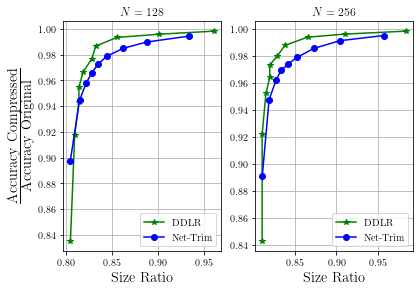

In [19]:
plt.rcParams.update({"text.usetex": True})

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout() 
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)

ax1.plot(sizes_with_layer2_128[1:]/initial_size, acc_DLR_layer2_128[1:]/origAccuracy, 'g-*', label=r'\textrm{DDLR}'  )
#ax1.plot(sizes_with_layer2_128/initial_size, acc_LR_finetuned_layer2_128/origAccuracy, 'r-^' , label=r'\textrm{ULR-ft}')
ax1.plot(nettrim_size_with_layer2_128[2:]/initial_size, acc_nettrim_layer2_128[2:]/origAccuracy, 'b-o',  label=r'\textrm{Net-Trim}')

ax2.plot(sizes_with_layer2_256[1:]/initial_size, acc_DLR_layer2_256[1:]/origAccuracy, 'g-*', label=r'\textrm{DDLR}'  )
#ax2.plot(sizes_with_layer2_256/initial_size, acc_LR_finetuned_layer2_256/origAccuracy, 'r-^' , label=r'\textrm{ULR-ft}')
ax2.plot(nettrim_size_with_layer2_256[2:]/initial_size, acc_nettrim_layer2_256[2:]/origAccuracy, 'b-o',  label=r'\textrm{Net-Trim}')

#ax3.plot(sizes_with_layer2_512/initial_size, acc_DLR_layer2_512/origAccuracy, 'g-*', label=r'\textrm{DDLR}' )
#ax3.plot(sizes_with_layer2_512/initial_size, acc_LR_finetuned_layer2_512/origAccuracy, 'r->', label=r'\textrm{ULR-ft}')
#ax3.plot(nettrim_size_with_layer2_512/initial_size, acc_nettrim_layer2_512/origAccuracy, 'b-o',   label=r'\textrm{Net-Trim}')

ax1.legend()
ax2.legend()
#ax3.legend()

ax1.set_title(r'$N=128$')
ax2.set_title(r'$N=256$')
#ax3.set_title(r'$N=512$')
ax1.grid()
ax2.grid()
#ax3.grid()

ax1.set_xlabel(r'$\textrm{Size Ratio}$',fontsize='x-large')
ax2.set_xlabel(r'$\textrm{Size Ratio}$',fontsize='x-large')
#ax3.set_xlabel(r'$\textrm{Size Percentage}$',fontsize='x-large')

ax1.set_ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large', ha='center')
#ax2.set_ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large', ha='center')
#ax3.set_ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large', ha='center')
if run_mode == 1:
    plt.savefig('Figures/MNIST_layer2_Ntr_1024_final.pdf')
else:
    plt.savefig('Figures/MNIST_layer2_Ntr_512_final.pdf')

In [20]:
if run_mode == 1:
    #size_DLR_with_combined_512, acc_DLR_combined_512 = getCombinedResultsDLR( 'approx_matrices/DLR_layer_1_Run1_N_512.npy', 'approx_matrices/DLR_layer_2_Run1_N_512.npy', 'Lenet_Mnist_Run1', ranks_layer1_512, ranks_layer2_512)
    size_DLR_with_combined_256, acc_DLR_combined_256 = getCombinedResultsDLR( 'approx_matrices/DLR_layer_1_Run1_N_256.npy', 'approx_matrices/DLR_layer_2_Run1_N_256.npy', 'Lenet_Mnist_Run1', ranks_layer1_256, ranks_layer2_256)
    size_DLR_with_combined_128, acc_DLR_combined_128 = getCombinedResultsDLR( 'approx_matrices/DLR_layer_1_Run1_N_128.npy', 'approx_matrices/DLR_layer_2_Run1_N_128.npy', 'Lenet_Mnist_Run1', ranks_layer1_128, ranks_layer2_128)

    # LR for both the layers 
    #model_file = 'Lenet_Mnist_Run1'
    #acc_LR_finetuned_combined_512 = getCombinedResultsLR(ranks_layer1_512, ranks_layer2_512, model_file, 512)
    #acc_LR_finetuned_combined_256 = getCombinedResultsLR(ranks_layer1_256, ranks_layer2_256, model_file, 256)
    #acc_LR_finetuned_combined_128 = getCombinedResultsLR(ranks_layer1_128, ranks_layer2_128, model_file, 128)

    #nettrim_size_combined_512, nettrim_acc_combined_512  = getCombinedResultsNettrim('approx_matrices/net_trim_layer_1_Run1_N_512.npy', 'approx_matrices/net_trim_layer_2_Run1_N_512.npy', 'Lenet_Mnist_Run1', 0.0001)
    nettrim_size_combined_256, nettrim_acc_combined_256  = getCombinedResultsNettrim('approx_matrices/net_trim_layer_1_Run1_N_256.npy', 'approx_matrices/net_trim_layer_2_Run1_N_256.npy', 'Lenet_Mnist_Run1', 0.0001)
    nettrim_size_combined_128, nettrim_acc_combined_128  = getCombinedResultsNettrim('approx_matrices/net_trim_layer_1_Run1_N_128.npy', 'approx_matrices/net_trim_layer_2_Run1_N_128.npy', 'Lenet_Mnist_Run1', 0.0001)
else:
    #size_DLR_with_combined_512, acc_DLR_combined_512 = getCombinedResultsDLR( 'approx_matrices/DLR_layer_1_Run2_N_512.npy', 'approx_matrices/DLR_layer_2_Run2_N_512.npy', 'Lenet_Mnist_Run2', ranks_layer1_512, ranks_layer2_512)
    size_DLR_with_combined_256, acc_DLR_combined_256 = getCombinedResultsDLR( 'approx_matrices/DLR_layer_1_Run2_N_256.npy', 'approx_matrices/DLR_layer_2_Run2_N_256.npy', 'Lenet_Mnist_Run2', ranks_layer1_256, ranks_layer2_256)
    size_DLR_with_combined_128, acc_DLR_combined_128 = getCombinedResultsDLR( 'approx_matrices/DLR_layer_1_Run2_N_128.npy', 'approx_matrices/DLR_layer_2_Run2_N_128.npy', 'Lenet_Mnist_Run2', ranks_layer1_128, ranks_layer2_128)

    # LR for both the layers 
    #model_file = 'Lenet_Mnist_Run2'
    #acc_LR_finetuned_combined_512 = getCombinedResultsLR(ranks_layer1_512, ranks_layer2_512, model_file, 512)
    #acc_LR_finetuned_combined_256 = getCombinedResultsLR(ranks_layer1_256, ranks_layer2_256, model_file, 256)
    #acc_LR_finetuned_combined_128 = getCombinedResultsLR(ranks_layer1_128, ranks_layer2_128, model_file, 128)

    #nettrim_size_combined_512, nettrim_acc_combined_512  = getCombinedResultsNettrim('approx_matrices/net_trim_layer_1_Run2_N_512.npy', 'approx_matrices/net_trim_layer_2_Run2_N_512.npy', 'Lenet_Mnist_Run2', 0.0001)
    nettrim_size_combined_256, nettrim_acc_combined_256  = getCombinedResultsNettrim('approx_matrices/net_trim_layer_1_Run2_N_256.npy', 'approx_matrices/net_trim_layer_2_Run2_N_256.npy', 'Lenet_Mnist_Run2', 0.0001)
    nettrim_size_combined_128, nettrim_acc_combined_128  = getCombinedResultsNettrim('approx_matrices/net_trim_layer_1_Run2_N_128.npy', 'approx_matrices/net_trim_layer_2_Run2_N_128.npy', 'Lenet_Mnist_Run2', 0.0001)

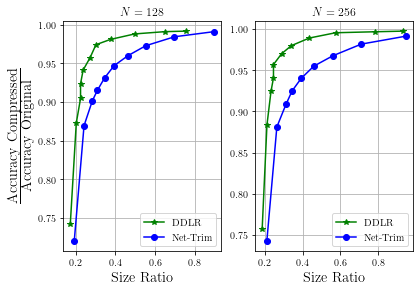

In [22]:
plt.rcParams.update({"text.usetex": True})

fig, (ax1, ax2) = plt.subplots(1,2)
fig.tight_layout() 
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)

ax1.plot(size_DLR_with_combined_128/initial_size, acc_DLR_combined_128/origAccuracy, 'g-*', label=r'\textrm{DDLR}'  )
#ax1.plot(size_DLR_with_combined_128/initial_size, acc_LR_finetuned_combined_128/origAccuracy, 'r-^' , label=r'\textrm{ULR-ft}')
ax1.plot(nettrim_size_combined_128[1:]/initial_size, nettrim_acc_combined_128[1:]/origAccuracy, 'b-o',  label=r'\textrm{Net-Trim}')

ax2.plot(size_DLR_with_combined_256/initial_size, acc_DLR_combined_256/origAccuracy, 'g-*', label=r'\textrm{DDLR}'  )
#ax2.plot(size_DLR_with_combined_256/initial_size, acc_LR_finetuned_combined_256/origAccuracy, 'r-^' , label=r'\textrm{ULR-ft}')
ax2.plot(nettrim_size_combined_256[2:]/initial_size, nettrim_acc_combined_256[2:]/origAccuracy, 'b-o',  label=r'\textrm{Net-Trim}')

#ax3.plot(size_DLR_with_combined_512/initial_size, acc_DLR_combined_512/origAccuracy, 'g-*', label=r'\textrm{DDLR}'  )
#ax3.plot(size_DLR_with_combined_512/initial_size, acc_LR_finetuned_combined_512/origAccuracy, 'r-^' , label=r'\textrm{ULR-ft}')
#ax3.plot(nettrim_size_combined_512/initial_size, nettrim_acc_combined_512/origAccuracy, 'b-o',  label=r'\textrm{Net-Trim}')

ax1.legend()
ax2.legend()
#ax3.legend()

ax1.set_title(r'$N=128$')
ax2.set_title(r'$N=256$')
#ax3.set_title(r'$N=512$')
ax1.grid()
ax2.grid()
#ax3.grid()

ax1.set_xlabel(r'$\textrm{Size Ratio}$',fontsize='x-large')
ax2.set_xlabel(r'$\textrm{Size Ratio}$',fontsize='x-large')
#ax3.set_xlabel(r'$\textrm{Size Percentage}$',fontsize='x-large')

ax1.set_ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large', ha='center')
#ax2.set_ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large', ha='center')
#ax3.set_ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large', ha='center')
if run_mode == 1:
    plt.savefig('Figures/MNIST_combined_Ntr_1024_final.pdf')
else:
    plt.savefig('Figures/MNIST_combined_Ntr_512_5_final.pdf')

In [23]:
size_DLR_with_combined_128/initial_size

array([0.7559087 , 0.65074506, 0.49795165, 0.37586098, 0.30212038,
       0.27213794, 0.23756359, 0.22450817, 0.22450817, 0.20298924,
       0.1730068 ])

In [24]:
 acc_DLR_combined_128/origAccuracy

array([0.99150877, 0.99085563, 0.9879164 , 0.98084041, 0.97398211,
       0.95699979, 0.94121487, 0.92357933, 0.90452862, 0.8727411 ,
       0.74286955])

In [25]:
nettrim_size_combined_128[1:]/initial_size

array([0.89796516, 0.69787962, 0.55336965, 0.46375996, 0.39359834,
       0.34551839, 0.30959348, 0.2838653 , 0.24213299, 0.19290506])

In [26]:
nettrim_acc_combined_128[1:]/origAccuracy

array([0.99085563, 0.98421509, 0.97267575, 0.95983013, 0.94687563,
       0.9309819 , 0.91508817, 0.90137164, 0.86936643, 0.72066186])

In [27]:
print(size_DLR_with_combined_256/initial_size, acc_DLR_combined_256/origAccuracy)

[0.93121145 0.78373025 0.57484356 0.43582587 0.34056634 0.28906496
 0.2460271  0.2460271  0.23297168 0.21145275 0.18606222] [0.99760504 0.99684302 0.99564554 0.98922269 0.9799695  0.97017198
 0.95699979 0.9408883  0.92445024 0.88362722 0.75658608]


In [28]:
acc_DLR_combined_256/origAccuracy

array([0.99760504, 0.99684302, 0.99564554, 0.98922269, 0.9799695 ,
       0.97017198, 0.95699979, 0.9408883 , 0.92445024, 0.88362722,
       0.75658608])

In [29]:
nettrim_size_combined_256[2:]/initial_size, nettrim_acc_combined_256[2:]/origAccuracy

(array([0.94719309, 0.71050736, 0.56032503, 0.45943817, 0.39285554,
        0.34477558, 0.31182191, 0.26387701, 0.21107009]),
 array([0.99150877, 0.98182013, 0.96766815, 0.95504028, 0.94023509,
        0.92499451, 0.90844763, 0.88112345, 0.74286955]))